# Machine Learning Applied to Synthetic Sitelle Data


In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
import tensorflow as tf
from keras.backend import clear_session
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Flatten, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn import preprocessing
from tqdm import tqdm_notebook as tqdm
from pickle import dump
from keras.backend import clear_session
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import KFold
from sklearn import metrics
import statistics
from scipy import interpolate
from scipy.stats import gaussian_kde


Using TensorFlow backend.


In [4]:
# Set Input Parameters
output_dir = '/home/carterrhea/Desktop/Test/'  # Include trailing /
syn_num = 1000  # Number of Synthetic Data

## Read in Spectra

In [2]:
# IF RESOLUTION IS SAMPLED USE THIS 
# This gets us the wavenumbers we are going to interpolate on
# We use this spectra because it is a nice looking (can easily see the lines -- not relevant here)
# spectra at a resolution of 5000 exactly. We want to keep that sampling :)
spec98_ = fits.open('Reference-Spectrum.fits')[1].data
channel = []
counts = []
for chan in spec98_:  
    channel.append(chan[0])
    counts.append(chan[1])
min_ = np.argmin(np.abs(np.array(channel)-14500))  # note that we cut the values a bit more than we did during the creation of the synthetic data
max_ = np.argmin(np.abs(np.array(channel)-15600))  # We do this to make sure all values are within the range and to avoid any extrapolation!
wavenumbers_syn = channel[min_:max_] 

In [5]:
# Read in Fits -- This is not particularly fast :S
Counts = []  # List containing the spectra
Param_dict = {}  # {spectrum_ct: [velocity, broadening]}
for spec_ct in range(syn_num):
    spectrum = fits.open(output_dir+'Spectrum_%i.fits'%spec_ct)
    header = spectrum[0].header
    spec = spectrum[1].data
    channel = []
    counts = []
    for chan in spec:  # Only want SN3 region
        channel.append(chan[0])
        counts.append(chan[1])
    # We need to find the min and max wavenumber that match our min/max from our synthetic spectra    
    # We go a bit further on either end for safety during the interpolation (so we don't need any extrapolation)
    min_ = np.argmin(np.abs(np.array(channel)-14400))
    max_ = np.argmin(np.abs(np.array(channel)-15700))
    f = interpolate.interp1d(channel[min_:max_], counts[min_:max_], kind='slinear')  # interpolate using a linear spline
    # Get fluxes of interest                                                                     
    coun = f(wavenumbers_syn)
    Counts.append(coun) 
    Param_dict[spec_ct] = [header['VELOCITY'], header['BROADEN']]  # Save velocity and broadening
vel_spec = [val[0] for val in list(Param_dict.values())]  # Read velocity into list
broad_spec = [val[1] for val in list(Param_dict.values())]  # Read broadening into list

## Setup Machine Learning Algorithm

In [6]:
activation = 'relu'  # activation function
initializer = 'he_normal'  # model initializer
input_shape = (None, len(Counts[0]), 1)  # shape of input spectra for the input layer
num_filters = [4,16]  # number of filters in the convolutional layers
filter_length = [8,4]  # length of the filters 
pool_length = 2  # length of the maxpooling
num_hidden = [256,128]  # number of nodes in the hidden layers
batch_size = 2  # number of data fed into model at once
max_epochs = 25  # maximum number of interations
lr = 0.0007  # initial learning rate
beta_1 = 0.9  # exponential decay rate  - 1st
beta_2 = 0.999  # exponential decay rate  - 2nd
optimizer_epsilon = 1e-08  # For the numerical stability
early_stopping_min_delta = 0.0001
early_stopping_patience = 4
reduce_lr_factor = 0.5
reuce_lr_epsilon = 0.009
reduce_lr_patience = 2
reduce_lr_min = 0.00008
loss_function = 'mean_squared_error'
metrics_ = ['accuracy', 'mae']
# Clear session for sanity :)
clear_session()
model = Sequential([
    InputLayer(batch_input_shape=input_shape),
    Conv1D(kernel_initializer=initializer, activation=activation, padding="same", filters=num_filters[0], kernel_size=filter_length[0]),
    Conv1D(kernel_initializer=initializer, activation=activation, padding="same", filters=num_filters[1], kernel_size=filter_length[1]),
    MaxPooling1D(pool_size=pool_length),
    Flatten(),
    Dropout(0.2),
    Dense(units=num_hidden[0], kernel_initializer=initializer, activation=activation),
    Dense(units=num_hidden[1], kernel_initializer=initializer, activation=activation),
    Dense(2),
])
# Set optimizer
optimizer = Adam(lr=lr, beta_1=beta_1, beta_2=beta_2, epsilon=optimizer_epsilon, decay=0.0)
# Set early stopping conditions
early_stopping = EarlyStopping(monitor='val_loss', min_delta=early_stopping_min_delta, 
                                       patience=early_stopping_patience, verbose=2, mode='min')
# Set learn rate reduction conditions
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, epsilon=reuce_lr_epsilon, 
                                  patience=reduce_lr_patience, min_lr=reduce_lr_min, mode='min', verbose=2)
# Compile CNN
model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics_)

/home/carterrhea/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


To test no scaling (other than the normal scaling), we can just use the data we read in since our synthetic spectra have already been scaled by the maximum value.

In [8]:
# Get number of sucessful cloudy runs
syn_num_pass = len(Counts)
# Create divisions
train_div = int(0.7*syn_num_pass)  # Percent of synthetic data to use as training
valid_div = int(0.9*syn_num_pass)  # Percent of synthetic data to use as validation
test_div = int(1.0*syn_num_pass)  # Percent of synthetic data to use as testing
# Set training set 
TraningSet = np.array(Counts[:train_div])
TraningSet = TraningSet.reshape(TraningSet.shape[0], TraningSet.shape[1], 1)
Traning_init_labels = np.array((vel_spec[0:train_div], broad_spec[0:train_div])).T
# Set validation set
ValidSet = np.array(Counts[train_div:valid_div])
ValidSet = ValidSet.reshape(ValidSet.shape[0], ValidSet.shape[1], 1)
Valid_init_labels = np.array((vel_spec[train_div:valid_div], broad_spec[train_div:valid_div])).T
model.fit(TraningSet, Traning_init_labels, validation_data=(ValidSet, Valid_init_labels), 
      epochs=10, verbose=2, callbacks=[reduce_lr,early_stopping])
model.save('CNN_trained.h5')
model.summary()

Train on 700 samples, validate on 200 samples
Epoch 1/10
 - 3s - loss: 6926.8499 - accuracy: 0.5971 - mae: 61.3165 - val_loss: 6321.1572 - val_accuracy: 0.5750 - val_mae: 56.1029
Epoch 2/10
 - 1s - loss: 5147.5604 - accuracy: 0.6329 - mae: 49.2847 - val_loss: 3530.2183 - val_accuracy: 0.8350 - val_mae: 40.9384
Epoch 3/10
 - 1s - loss: 1794.5521 - accuracy: 0.8971 - mae: 28.3811 - val_loss: 576.1165 - val_accuracy: 0.9650 - val_mae: 16.9546
Epoch 4/10
 - 1s - loss: 603.7346 - accuracy: 0.9343 - mae: 17.4610 - val_loss: 514.4747 - val_accuracy: 0.9650 - val_mae: 16.5065
Epoch 5/10
 - 1s - loss: 528.3834 - accuracy: 0.9557 - mae: 16.4571 - val_loss: 430.6654 - val_accuracy: 0.9650 - val_mae: 15.2681
Epoch 6/10
 - 1s - loss: 441.0608 - accuracy: 0.9571 - mae: 15.3234 - val_loss: 385.7453 - val_accuracy: 0.9650 - val_mae: 14.5634
Epoch 7/10
 - 1s - loss: 426.7855 - accuracy: 0.9557 - mae: 15.1410 - val_loss: 352.6820 - val_accuracy: 0.9650 - val_mae: 13.8803
Epoch 8/10
 - 1s - loss: 387.483

In [9]:
# Apply on test test
TestSet = np.array(Counts[valid_div:test_div])
TestSet = TestSet.reshape(TestSet.shape[0], TestSet.shape[1], 1)
TestSetLabels = np.array((vel_spec[valid_div:test_div], broad_spec[valid_div:test_div])).T
test_predictions = model.predict(TestSet)

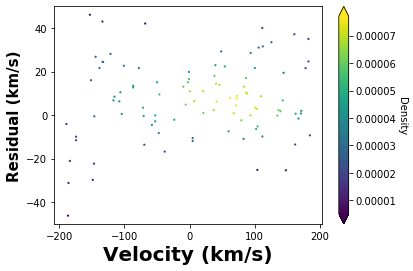

In [10]:
# Calculate the errors
vel_error = [(TestSetLabels[i,0]-test_predictions[i,0]) for i in range(len(test_predictions))]
# Calculate the point density
x = TestSetLabels[:,0]
y = vel_error
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# Plots
plt.scatter(x, y, c=z, s=5, edgecolor='')
plt.xlabel('Velocity (km/s)', fontsize = 20, fontweight='bold')
plt.ylabel('Residual (km/s)', fontsize = 15, fontweight='bold')
cbar = plt.colorbar(extend='both')
cbar.set_label('Density', rotation=270, labelpad=10)
plt.ylim(-50,50)
plt.savefig('Vel_Residual.png')

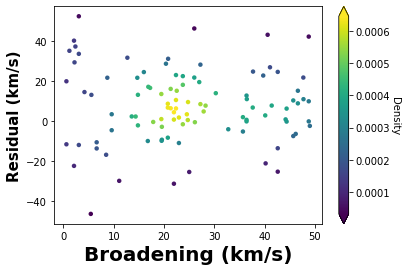

In [11]:
broad_x = [TestSetLabels[i,1] for i in range(len(test_predictions))]
vel_error = [(TestSetLabels[i,0]-test_predictions[i,0]) for i in range(len(test_predictions))]
# Calculate the point density
x = broad_x
y = vel_error
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# Plot
plt.scatter(x, y, c=z, s=20, edgecolor='')
plt.xlabel('Broadening (km/s)', fontsize = 20, fontweight='bold')
plt.ylabel('Residual (km/s)', fontsize = 15, fontweight='bold')
cbar = plt.colorbar(extend='both')
cbar.set_label('Density', rotation=270, labelpad=10)
plt.savefig('Broad_Residual.png')